# Exoplanet Transit Analysis: Real Data + Model Fitting

This notebook demonstrates how to:
1. Download and clean a real Kepler/TESS light curve (using `lightkurve`).
2. Fold the light curve on the orbital period of a known planet.
3. Fit a simple BATMAN transit model to estimate $R_p / R_s$ (planet-to-star radius ratio).

---

## Part A – Load and prepare real light curve

c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


SearchResult containing 50 data products.

 #       mission      year   author   exptime         target_name          distance
                                         s                                  arcsec 
--- ----------------- ---- ---------- ------- ---------------------------- --------
  0 Kepler Quarter 02 2009     Kepler      60                kplr011904151      0.0
  1 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  2 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  3 Kepler Quarter 03 2009     Kepler      60                kplr011904151      0.0
  4 Kepler Quarter 00 2009     Kepler    1800                kplr011904151      0.0
  5 Kepler Quarter 01 2009     Kepler    1800                kplr011904151      0.0
  6 Kepler Quarter 02 2009     Kepler    1800                kplr011904151      0.0
  7 Kepler Quarter 03 2009     Kepler    1800                kplr011904151      0.0
  8 Kepler Quarter 07 2010     Ke

c:\Users\nicek\anaconda3\envs\anaconda-toolbox\Lib\site-packages\lightkurve\search.py:420: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

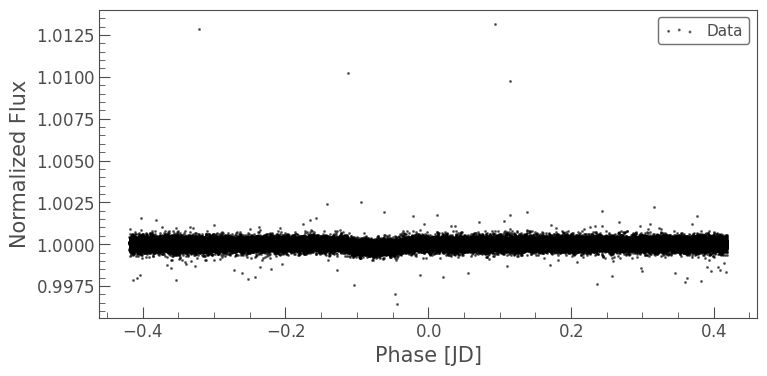

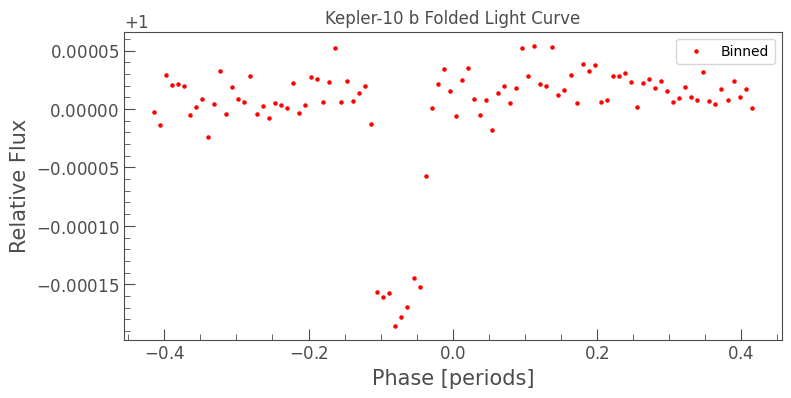

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt

# Step 1: Search for a target star
search = lk.search_lightcurve('Kepler-10', mission='Kepler')
print(search)

# Step 2: Download the first available light curve
lc = search.download()
if lc is None:
    raise ValueError('No light curve found. Try another star or mission.')

# Step 3: Clean and normalize
lc = lc.remove_nans().normalize()

# Step 4: Fold on known orbital period (Kepler-10 b ≈ 0.8375 days)
period = 0.8375
folded_lc = lc.fold(period=period)

# Step 5: Plot folded light curve
plt.figure(figsize=(10,5))
folded_lc.scatter(color='k', alpha=0.5, s=5, label='Data')
folded_lc.bin(bins=100).scatter(color='red', s=20, label='Binned')
plt.xlabel('Phase [periods]')
plt.ylabel('Relative Flux')
plt.title('Kepler-10 b Folded Light Curve')
plt.legend()
plt.show()

## Part B – Fit BATMAN model

C:\Users\nicek\AppData\Local\Temp\ipykernel_20596\1364605858.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(batman_model, t, flux, p0=p0)


Best-fit Rp/Rs: -0.0018


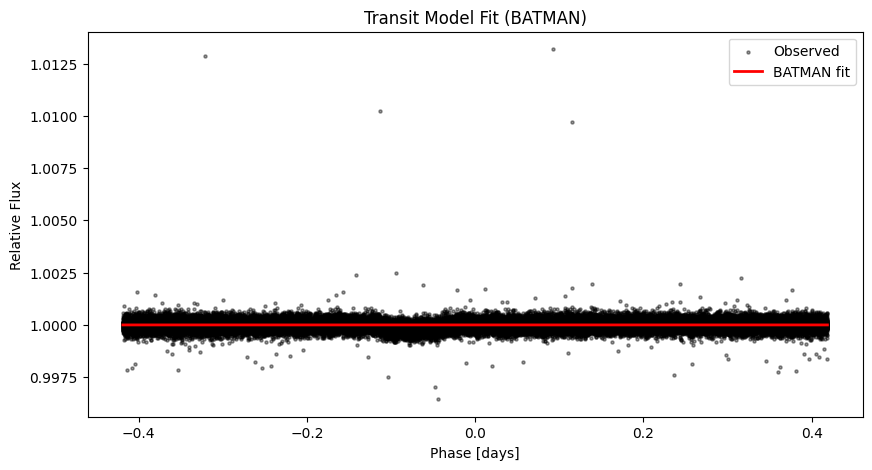

In [2]:
import numpy as np
import batman
from scipy.optimize import curve_fit

# Extract folded data
t = folded_lc.time.value  # in days
flux = folded_lc.flux.value

# Define BATMAN model wrapper
def batman_model(time, rp_rs, t0):
    params = batman.TransitParams()
    params.t0 = 0.0  # reference mid-transit
    params.per = period
    params.rp = rp_rs
    params.a = 15.0
    params.inc = 89.0
    params.ecc = 0.0
    params.w = 90.0
    params.limb_dark = 'quadratic'
    params.u = [0.3, 0.2]

    model = batman.TransitModel(params, time)
    return model.light_curve(params)

# Initial guesses: Rp/Rs ~ 0.01–0.02, t0 ~ 0
p0 = [0.015, 0.0]

# Fit using curve_fit
popt, pcov = curve_fit(batman_model, t, flux, p0=p0)
rp_rs_fit, t0_fit = popt

print(f"Best-fit Rp/Rs: {rp_rs_fit:.4f}")

# Compare fit vs. data
flux_fit = batman_model(t, rp_rs_fit, t0_fit)

plt.figure(figsize=(10,5))
plt.scatter(t, flux, color='k', alpha=0.4, s=5, label='Observed')
plt.plot(t, flux_fit, 'r-', lw=2, label='BATMAN fit')
plt.xlabel('Phase [days]')
plt.ylabel('Relative Flux')
plt.title('Transit Model Fit (BATMAN)')
plt.legend()
plt.show()

### Notes
- To use a different target, **only change this line in Part A**:
  ```python
  search = lk.search_lightcurve('Kepler-10', mission='Kepler')
  ```
  Replace `'Kepler-10'` with another star (e.g., `'Kepler-11'`, `'TIC 141914082'` for TESS).
- Update `period = ...` with the planet’s orbital period (in days).
- The fitting in Part B will automatically re-use that period.
